In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import os
from sklearn.decomposition import PCA

import performance

## Eigen Portfolio Replication for a Basket of Securities
### Introduction
**The idea of using Principal Component Analysis (PCA) to extract factors from a basket of securities is not new.** In this project, we borrow the idea mentioned in Dr. Marco Avellaneda's paper on statsitical arbitrage (https://math.nyu.edu/~avellane/AvellanedaLeeStatArb071108.pdf), and track the performance of eigen portfolios. This approach uses historical daily share price of N stocks going back M days, and applies PCA on the correlation matrix of standardized returns. 

**Specifically in this project, we use top 100 stocks from S&P 500 as our trading universe and one year as look back window as we construct the correlation matrix.** In particular, we do not wish to construct an eigen portfolio for S&P 100, but instead we wish to construct one for these 100 stocks. The reason is that we do not want to face the issue of survivorship bias in S&P 100 index, as it is not stationary in its holdings due to frequent additions and deletions of companies. A lot of articles and projects online are subjective to this bias, in the sense that many compare the eigen portfolio performance with the index performance over a long period of time (10+ years), without considering the changes in index composition.

### Historical Dataset
**In this project, we define our static trading universe as 99 selected stocks from S&P 500, dating from 2015-07-06 to 2022-12-30.** To see the full list of tickers, please see SP 100 tickers.csv under yfinance data folder. We use dividend adjusted price for this exercise, and the dataset does not have missing price values.

In [2]:
data = pd.read_csv('./data/SP 100 Daily Data.csv')

In [3]:
# we drop ticker "DOW" due to its relatively short history (IPO in 2019).
# the remaining 99 stocks have full history from 2015-07-06 to 2022-12-30. This will be our backtesting period.
price_df = data.loc[(data['Type']=='Adj Close')&(data['Ticker']!='DOW')].pivot_table(
    index='Date',columns='Ticker',values='Price').dropna()
price_df.head(5)

Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-06,28.502367,48.501278,42.805706,85.402031,80.500000,50.658939,2.47,122.848717,80.816475,21.802000,...,108.606392,80.921669,75.608353,34.138199,64.487404,32.283226,66.150352,44.779591,61.275921,57.053555
2015-07-07,28.432241,48.743008,43.210186,86.577713,80.589996,50.953808,2.09,123.556389,81.369545,21.836000,...,107.308388,82.182892,76.265396,34.036407,64.156052,32.427341,67.591270,44.628849,62.340408,57.288597
2015-07-08,27.726463,48.103142,42.384010,85.647697,79.989998,50.093796,2.01,121.107338,80.391029,21.485001,...,105.601425,80.593735,74.693169,33.410019,63.171532,32.344017,66.553185,43.835457,61.723682,56.666424
2015-07-09,27.160944,48.323544,42.332371,85.761742,80.470001,50.585224,1.98,120.312225,80.314468,21.719500,...,106.099274,80.930069,74.896530,33.637081,63.474472,32.121815,69.373047,44.033802,61.487133,56.410637
2015-07-10,27.887081,49.219349,42.969215,86.665428,80.589996,51.289623,1.96,122.530640,81.190849,22.175501,...,108.597496,82.250160,75.843018,34.012920,64.771408,32.635651,72.130936,44.493973,61.774357,56.839256


### Standardized Return Calculation
**We take a two-step approach to prepare the data for PCA analysis:**
- Calculate daily return based on adjusted close price
- Standardize returns so that different stock return volatilities are on the same scale. According to Dr. Avellaneda's paper, this can be achieved by applying the following,

*"Let us represent the stocks return data, on any given date $t_{0}$, going back $M+1$ days as a matrix
$$
R_{i,k} = \frac{S_{i,t_{0}-(k-1)\Delta t} - S_{i,t_{0}-k\Delta t}}{S_{i,t_{0}-k\Delta t}}, k=1,...,M, i=1,...,N,
$$
where $S_{i,t}$ is the price of stock $i$ at time $t$ adjusted for dividends and $\Delta t$=1/252. Since some stocks are more volatile than others, it is convenient to work with standardized returns,
$$
Y_{i,k} = \frac{R_{i,k}-\bar R_{i}}{\bar \sigma_{i}},
$$
where
$$
\bar R_{i} = \frac{1}{M}\Sigma_{k=1}^{M}R_{i,k},
$$
and
$$
\bar \sigma_{i}=\frac{1}{M-1}\Sigma_{k=1}^{M}(R_{i,k}-\bar R_{i})^{2}."
$$*

**As an example, we will perform this exercise on Jan 2nd, 2019, using 1-year look back window.** The choice of computed date and look back window is completely arbitrary, and we can theoratically slice historical data in a more intellectual way (e.g., use market regime models). This exercise tends to be illustrative.

**We compute and standardize the daily returns, and compute the correlation matrix.** Note that the dimension of correlation matrix is 99 by 99, which corresponds to the number of securities in our trading universe.

In [4]:
r_ik = (price_df/price_df.shift()-1).dropna()
r_ik_2018 = r_ik.loc['2018-01-01':'2018-12-31']

In [5]:
y_ik = (r_ik_2018 - r_ik_2018.mean())/r_ik_2018.std()

In [6]:
rho_ij = y_ik.corr()
rho_ij

Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,1.000000,0.317690,0.571416,0.616584,0.668567,0.256320,0.364347,0.469515,0.238687,0.661171,...,0.531642,0.497395,0.452200,0.371832,0.704296,0.131256,0.367739,0.414910,0.308229,0.435923
ABBV,0.317690,1.000000,0.499467,0.482001,0.381202,0.348677,0.243768,0.561311,0.255820,0.329813,...,0.481211,0.316600,0.365950,0.413914,0.428667,0.286413,0.358161,0.397479,0.302892,0.352451
ABT,0.571416,0.499467,1.000000,0.661578,0.648904,0.448020,0.431614,0.605471,0.288748,0.631584,...,0.616116,0.544341,0.529163,0.521047,0.697872,0.364410,0.444986,0.498295,0.416849,0.532085
ACN,0.616584,0.482001,0.661578,1.000000,0.651186,0.419120,0.364896,0.554174,0.319118,0.632018,...,0.600630,0.574647,0.471252,0.579403,0.738608,0.326684,0.326499,0.509594,0.390834,0.556482
ADBE,0.668567,0.381202,0.648904,0.651186,1.000000,0.293013,0.444407,0.542040,0.196694,0.759208,...,0.563152,0.468092,0.463130,0.378803,0.822347,0.064802,0.355740,0.367033,0.271531,0.389331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VZ,0.131256,0.286413,0.364410,0.326684,0.064802,0.206426,0.073811,0.355925,0.380221,0.076551,...,0.390142,0.291953,0.269002,0.403901,0.163152,1.000000,0.323102,0.309604,0.388949,0.286982
WBA,0.367739,0.358161,0.444986,0.326499,0.355740,0.314203,0.241488,0.513822,0.234164,0.336317,...,0.527249,0.425615,0.470184,0.437530,0.402014,0.323102,1.000000,0.363932,0.427709,0.375984
WFC,0.414910,0.397479,0.498295,0.509594,0.367033,0.467994,0.262094,0.485297,0.207003,0.402279,...,0.467775,0.464759,0.464355,0.745652,0.480816,0.309604,0.363932,1.000000,0.349757,0.487219


### Principal Component Analysis
**We perform PCA on the correlation matrix, and rank the eigenvalues in decreasing order.** We plot the explained variance by each component of the 20 largest eigenvalues, and observe that a few large eigenvalues are detached from the rest of the spectrum. We can also plot the density of states. Both graphs show that the top eigenvalues differentiate from the rest in a significant manner. In the density chart, the red bar represents the "market" eigenvalue, which explains over 60% of total variance.

In [7]:
pca = PCA(n_components = len(rho_ij))
pca.fit(rho_ij)

PCA(n_components=99)

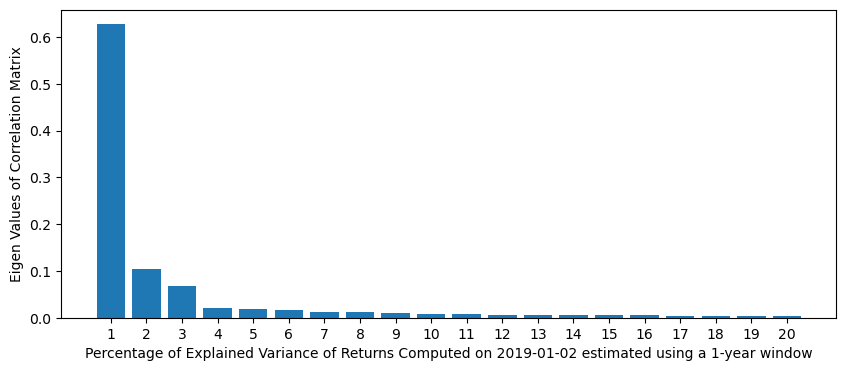

In [8]:
plt.figure(figsize=(10,4))
plt.bar(np.arange(1,21),pca.explained_variance_ratio_[:20])
plt.xticks(np.arange(1,21))
plt.xlabel('Percentage of Explained Variance of Returns Computed on 2019-01-02 estimated using a 1-year window')
plt.ylabel('Eigen Values of Correlation Matrix')
plt.show()

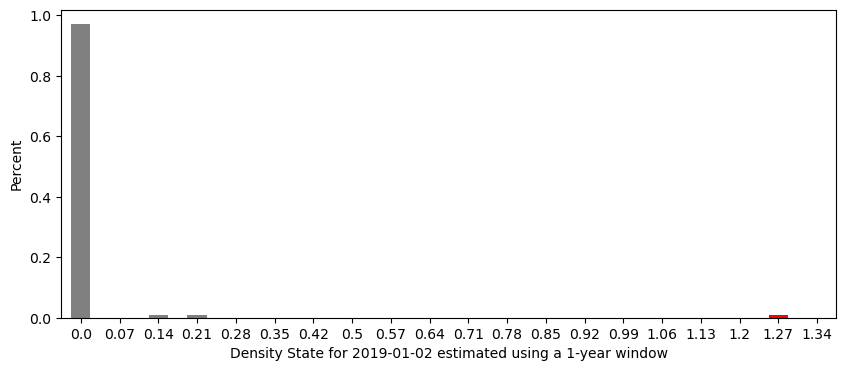

In [9]:
slicing = np.linspace(pca.explained_variance_.min()*0.99,pca.explained_variance_.max(),20)
density_pca = pd.concat([pd.cut(pca.explained_variance_,bins=slicing).describe()['freqs'],pd.Series([0])])
density_pca.index = slicing.round(2)
density_pca.plot.bar(figsize=(10,4),color=['gray']*(len(density_pca)-2)+['red'])
plt.xticks(rotation=0)
plt.ylabel('Percent')
plt.xlabel('Density State for 2019-01-02 estimated using a 1-year window')
plt.show()

### Factor Loadings
**Next, we examine the loadings of each stock under the first three significant components.** We sort the factor loadings in descending orders. In addition, we re-label the chart with the stock's corresponding sector. In this new ordering scheme, we discovery that the neighbors of any company tend to be in the same sector or industry group. For example, companies with the most positive loadings tend to fall under Utilities industry, and the ones with most negative loadings tend to be companies in financial services. 

**This observation agrees with what Dr. Avellaneda's paper calls 'coherence'.** It claims that *"As we descend in the spectrum towards the noise eigenvectors, the property that nearby coefficients correspond to firms in the same industry is less true and coherence will not hold for eigenvectors of the noise spectrum."* Here, we replicate the same exercise for the second and third components.

In [10]:
loadings = pd.DataFrame(pca.components_.T,columns=['PC'+str(i) for i in range(1,len(rho_ij)+1)],index=rho_ij.index)
loadings[['PC1','PC2','PC3']]

,PC1,PC2,PC3
Ticker,,,
AAPL,-0.119862,0.075650,-0.118189
ABBV,-0.062981,-0.092237,-0.057220
ABT,-0.119017,-0.030955,-0.098996
ACN,-0.121058,-0.030978,-0.083931
ADBE,-0.150741,0.132116,-0.170157
...,...,...,...
VZ,0.047491,-0.213419,-0.023701
WBA,-0.041372,-0.098885,-0.018088
WFC,-0.109743,-0.122897,0.134650


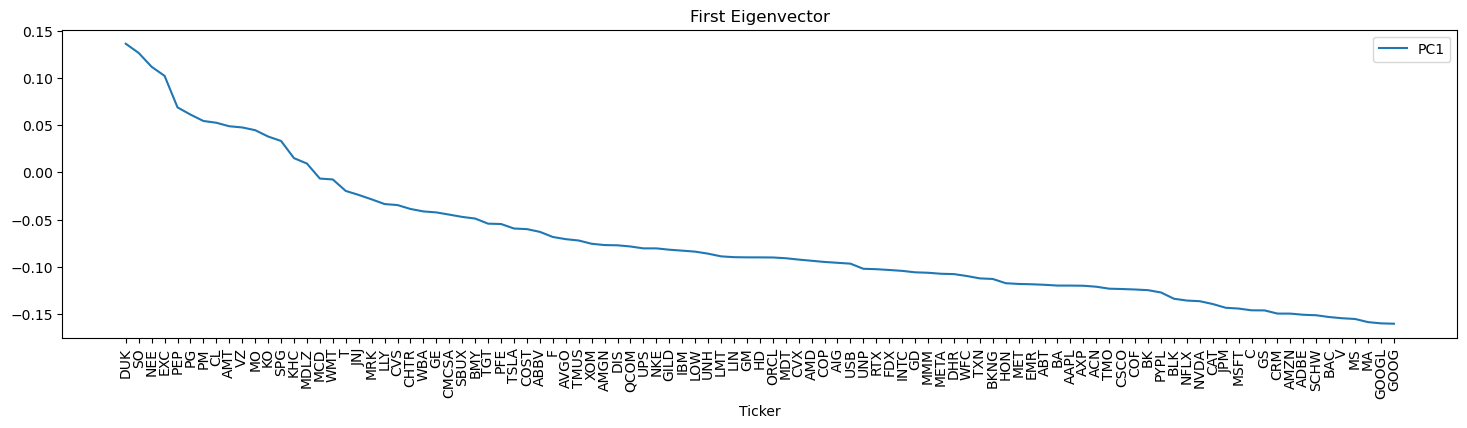

In [11]:
pc1_sort = loadings[['PC1']].sort_values('PC1',ascending=False)
pc1_sort.plot(figsize=(18,4))
plt.xticks(range(len(pc1_sort)),pc1_sort.index,rotation=90)
plt.title('First Eigenvector')
plt.show()

**Before we examine different significant components, we offer the sector breakdown of 99 selected stocks in our trading universe.** The most common sector industries are Financial Services, Healthcare, and Technology.

In [12]:
sector_name = pd.read_csv('./data/SP 100 Sector Data.csv')
print(tabulate(sector_name.loc[sector_name['Ticker']!='DOW'].groupby('Sector').count(),headers=['Sector','Count']))

Sector                    Count
----------------------  -------
Basic Materials               1
Communication Services       10
Consumer Cyclical            10
Consumer Defensive           11
Energy                        3
Financial Services           17
Healthcare                   15
Industrials                  12
Real Estate                   2
Technology                   14
Utilities                     4


**As mentioned above, we replace the tickers with their corresponding sector industry.** An interesting observation is the clustering effect of stocks in the same industry. And this is manefested across all three significant components.

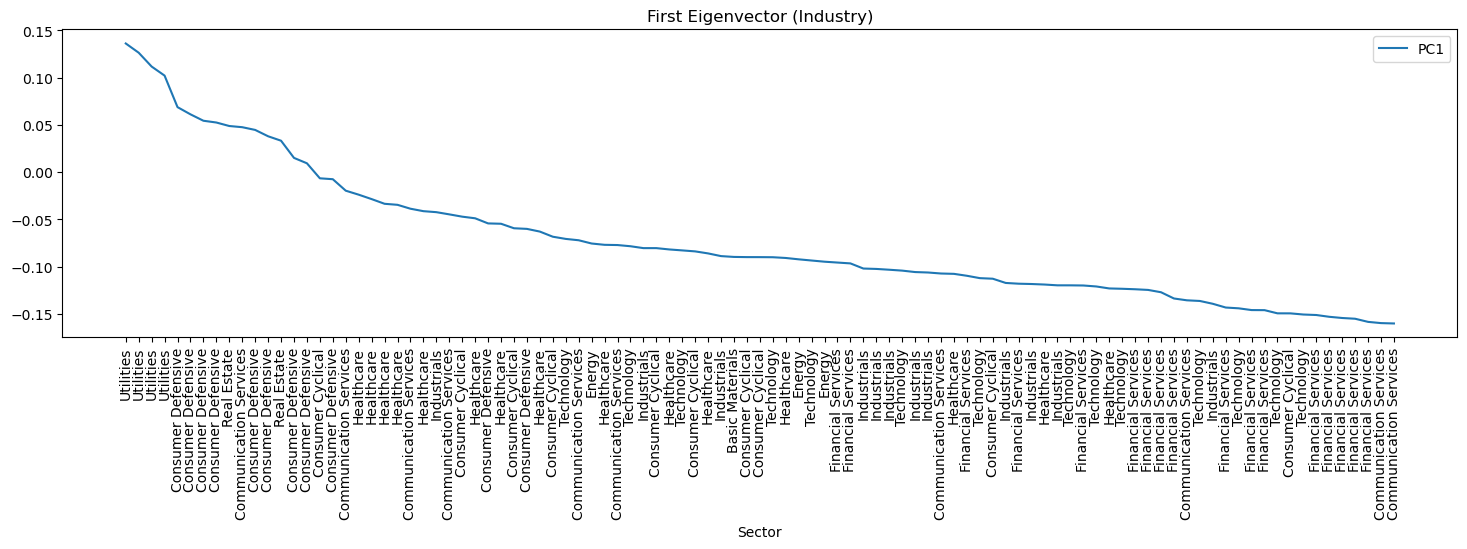

In [13]:
pc1_sort_industry = pc1_sort.merge(sector_name,how='left',left_index=True,right_on='Ticker')[['PC1','Sector']].set_index('Sector')
pc1_sort_industry.plot(figsize=(18,4))
plt.xticks(range(len(pc1_sort_industry)),pc1_sort_industry.index,rotation=90)
plt.title('First Eigenvector (Industry)')
plt.show()

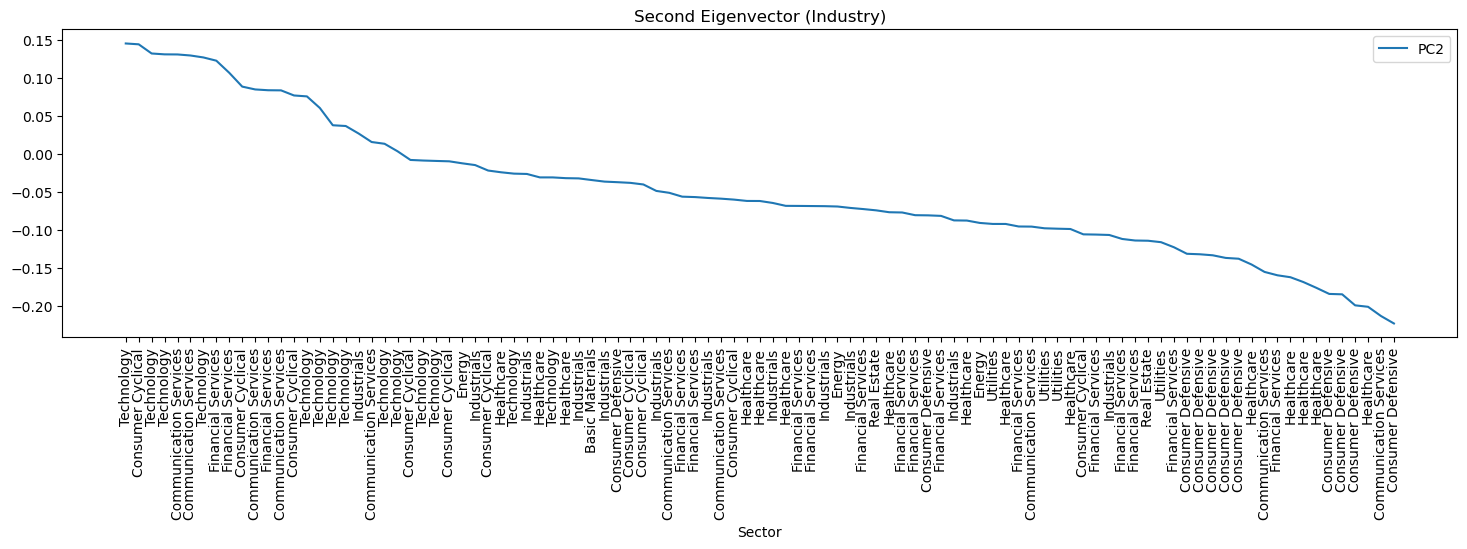

In [14]:
pc2_sort = loadings[['PC2']].sort_values('PC2',ascending=False)
pc2_sort_industry = pc2_sort.merge(sector_name,how='left',left_index=True,right_on='Ticker')[['PC2','Sector']].set_index('Sector')
pc2_sort_industry.plot(figsize=(18,4))
plt.xticks(range(len(pc2_sort_industry)),pc2_sort_industry.index,rotation=90)
plt.title('Second Eigenvector (Industry)')
plt.show()

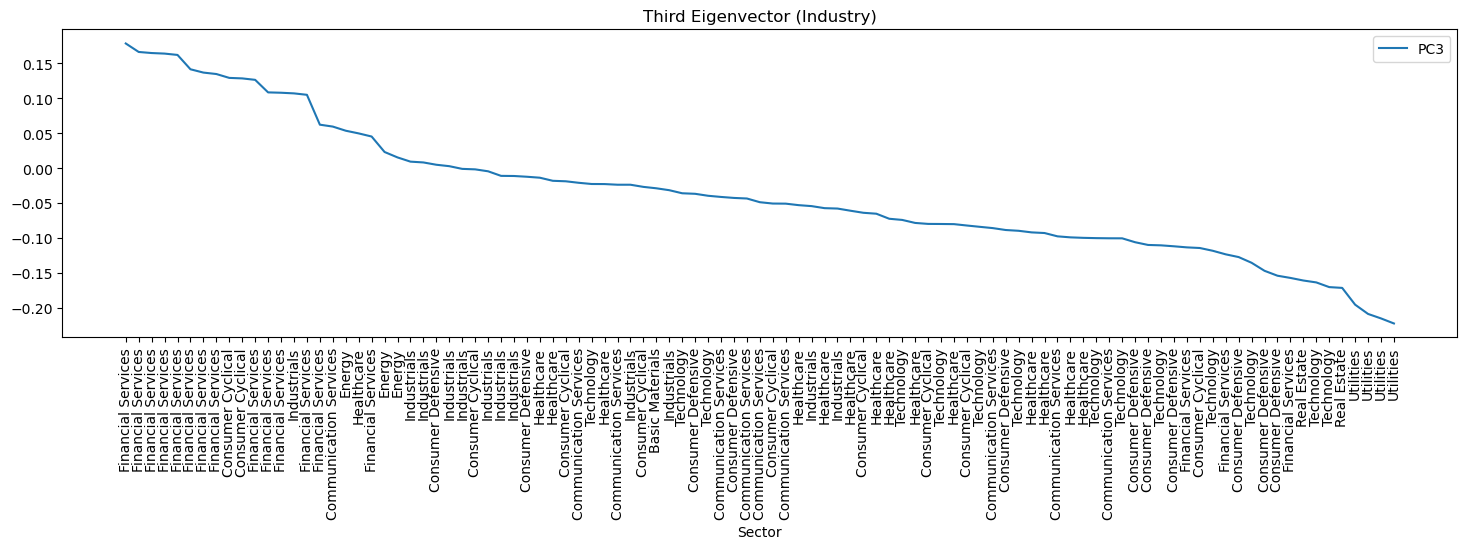

In [15]:
pc3_sort = loadings[['PC3']].sort_values('PC3',ascending=False)
pc3_sort_industry = pc3_sort.merge(sector_name,how='left',left_index=True,right_on='Ticker')[['PC3','Sector']].set_index('Sector')
pc3_sort_industry.plot(figsize=(18,4))
plt.xticks(range(len(pc3_sort_industry)),pc3_sort_industry.index,rotation=90)
plt.title('Third Eigenvector (Industry)')
plt.show()

### Eigen Portfolio
**In this section, we construct 3 different eigen portfolios (each represents a significant eigen vector), and compare their performance against a benchmark portfolio.** Typically the choice of benchmark portfolio includes a portfolio weighted by market cap. However, due to the limited free open source on historical market caps (e.g., we do not have credible sources of XOM's market cap on 2018-01-02), we simply use an equal-weight portfolio as benchmark. This is a logical approach, considering the stock selection in our exercise already includes 99 large cap blue chips stocks that are actively traded in the market.

**To determine the weight of each of the stocks for an eigen portfolio, we look at both the loading of a stock for a given eigen vector and the stock's volatility, which was computed in the previous section.** Specifically, the volatility-adjusted loading of a stock for a given eigen vector is defined as following,
$$
Q_{i}^{(j)} =  \frac{v_{i}^{(j)}}{\bar \sigma_{i}},
$$
where $Q_{i}^{j}$ is the volatility-adjusted loading for stock $i$ for eigen vector $j$, <br>
$v_{i}^{(j)}$ is the loading for stock $i$ for eigen vector $j$, and <br>
$\bar \sigma_{i}$ is volatility of the stock, computed before.

The actual weight of a stock for a given eigen vector is then re-scaled such that the sum of weights for all 99 stocks equals to 1.

In [16]:
eigen_weight = loadings[['PC1','PC2','PC3']]
eigen_weight = eigen_weight.div(r_ik_2018.std(),axis=0)
weights = eigen_weight.apply(lambda x: x/x.sum())

print('Sanity Check:')
print(weights.sum())

weights

Sanity Check:
PC1    1.0
PC2    1.0
PC3    1.0
dtype: float64


,PC1,PC2,PC3
Ticker,,,
AAPL,0.016419,-0.010554,0.026377
ABBV,0.007046,0.010509,0.010429
ABT,0.020828,0.005517,0.028226
ACN,0.020515,0.005347,0.023173
ADBE,0.016731,-0.014935,0.030769
...,...,...,...
VZ,-0.009187,0.042047,0.007469
WBA,0.005899,0.014361,0.004202
WFC,0.018433,0.021024,-0.036847


In [17]:
pc1_return = r_ik_2018.multiply(weights['PC1'],axis=1).sum(axis=1)
pc2_return = r_ik_2018.multiply(weights['PC2'],axis=1).sum(axis=1)
pc3_return = r_ik_2018.multiply(weights['PC3'],axis=1).sum(axis=1)
equal_weight_return = r_ik_2018.mean(axis=1)

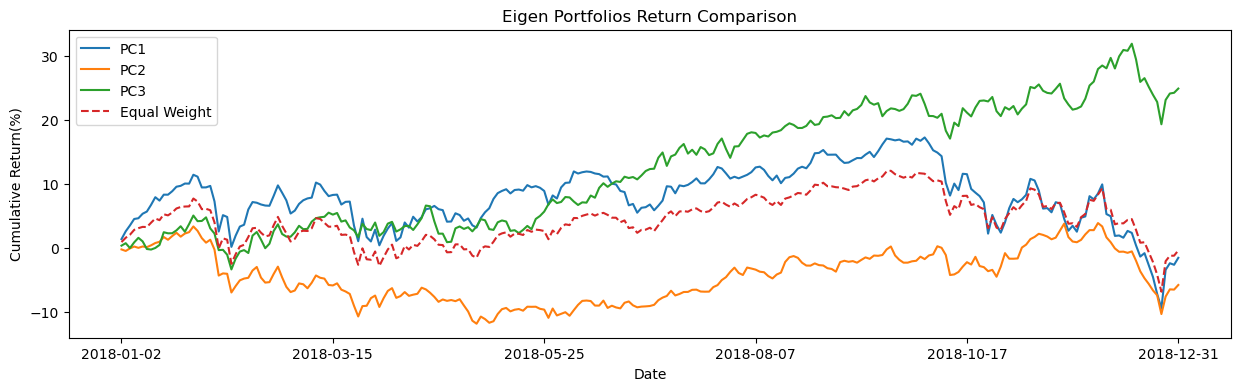

In [18]:
plt.figure(figsize=(15,4))
(pc1_return.cumsum()*100).plot(label='PC1')
(pc2_return.cumsum()*100).plot(label='PC2')
(pc3_return.cumsum()*100).plot(label='PC3')
(equal_weight_return.cumsum()*100).plot(label='Equal Weight',style='--')
plt.legend()
plt.ylabel('Cumulative Return(%)')
plt.title('Eigen Portfolios Return Comparison')
plt.show()

To do:
- one interesting discovery: first component loadings are not all positive as described in the paper. anything missing or is it the nature of stock selections? (SP 100 vs. SP 500)

- more performance related comparison.